* PAPER - Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation - [PDF](https://arxiv.org/pdf/1802.02611.pdf)
* PAPER - Rethinking Atrous Convolution for Semantic Image Segmentation - [PDF](https://arxiv.org/pdf/1706.05587.pdf)
* PAPER - DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs - [PDF](https://arxiv.org/pdf/1606.00915.pdf)

![](https://github.com/lattice-ai/DeepLabV3-Plus/raw/master/assets/deeplabv3_plus_diagram.png)
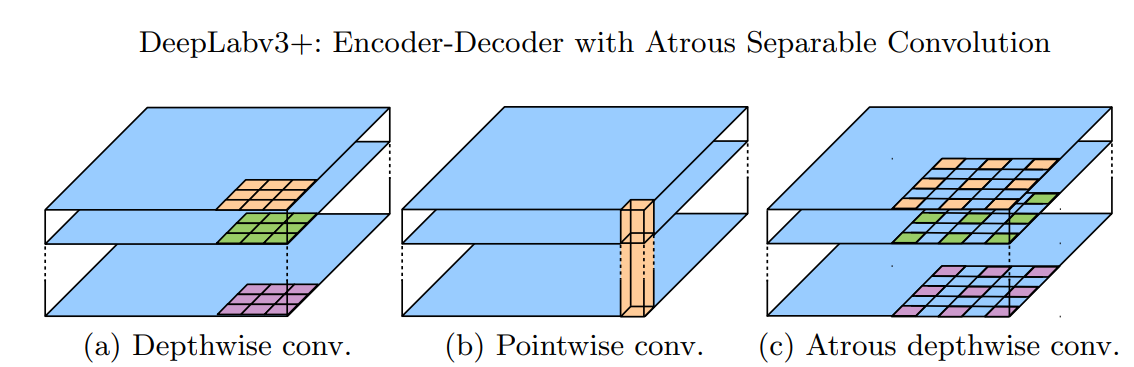

# 준비

## 라이브러리 호출

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 데이터

In [16]:
len(glob(os.path.join(DATA_DIR, "Images/*")))

28280

In [25]:
IMAGE_SIZE = 512
BATCH_SIZE = 1
NUM_CLASSES = 20
DATA_DIR = "D:/Dataset/dataset/Sementic_Segmentation/instance-level_human_parsing/Training/"
NUM_TRAIN_IMAGES = 2000
NUM_VAL_IMAGES = 100

train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]

## 데이터 셋

In [26]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [27]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(2, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, 256, 256, 1), dtype=tf.float32, name=None))>
Val Dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(2, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, 256, 256, 1), dtype=tf.float32, name=None))>


# 모델링

## ASPP

In [28]:
def ASPP(inputs):
    """shape"""
    shape = inputs.shape
    
    """ASPP(Atrous Spatial Pyramid Pooling)"""
    # Image Pooling
    y_pool = tf.keras.layers.AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y_pool = tf.keras.layers.Conv2D(filters=256, kernel_size=1, padding="same", use_bias=False)(y_pool)
    y_pool = tf.keras.layers.BatchNormalization()(y_pool)
    y_pool = tf.keras.layers.Activation("relu")(y_pool)
    y_pool = tf.keras.layers.UpSampling2D( (shape[1], shape[2]), interpolation="bilinear")(y_pool)
    # 1X1 Conv
    y_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=1, padding="same", use_bias=False)(inputs)
    y_1 = tf.keras.layers.BatchNormalization()(y_1)
    y_1 = tf.keras.layers.Activation("relu")(y_1)
    # 3X3 Conv dilation_rate:6
    y_6 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding="same", use_bias=False)(inputs)
    y_6 = tf.keras.layers.BatchNormalization()(y_6)
    y_6 = tf.keras.layers.Activation("relu")(y_6)
    # 3X3 Conv dilation_rate:12
    y_12 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding="same", use_bias=False)(inputs)
    y_12 = tf.keras.layers.BatchNormalization()(y_12)
    y_12 = tf.keras.layers.Activation("relu")(y_12)
    # 3X3 Conv dilation_rate:18
    y_18 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding="same", use_bias=False)(inputs)
    y_18 = tf.keras.layers.BatchNormalization()(y_18)
    y_18 = tf.keras.layers.Activation("relu")(y_18)
    
    # Concat
    y = tf.keras.layers.Concatenate()([y_pool, y_1, y_6, y_12, y_18])
    
    # 1X1 Conv
    y = tf.keras.layers.Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation("relu")(y)
    
    return y

## DeeplabV3+

In [29]:
def Deeplabv3plus(shape):
    """ inputs"""
    inputs = keras.layers.Input(shape)
    
    """ Pre-trained ResNet50 """
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    
    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer("conv4_block6_out").output
    x_a = ASPP(image_features)
    x_a = tf.keras.layers.UpSampling2D( (4,4), interpolation="bilinear")(x_a)
    
    """ Get low_level feature """
    x_b = base_model.get_layer("conv2_block2_out").output
    x_b = tf.keras.layers.Conv2D(filters=48, kernel_size=1, padding="same", use_bias=False)(x_b)
    x_b = tf.keras.layers.BatchNormalization()(x_b)
    x_b = tf.keras.layers.Activation("relu")(x_b)
    
    # Concatenate
    x = tf.keras.layers.Concatenate()([x_a, x_b])
    
    # 3X3 Conv
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    # 3X3 Conv
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    # Upsampleing
    x = tf.keras.layers.UpSampling2D( (4,4), interpolation="bilinear")(x)
    
    """ Outputs """
    x = tf.keras.layers.Conv2D(NUM_CLASSES, (1,1), name="output_layer")(x)
    
    """ Model """
    model = tf.keras.models.Model(inputs=inputs, outputs=x)
    return model

In [30]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
model = Deeplabv3plus(input_shape)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

 batch_normalization_29 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 up_sampling2d_8 (UpSampling2D)  (None, 16, 16, 256)  0          ['activation_25[0][0]']          
                                                                                                  
 activation_26 (Activation)     (None, 16, 16, 256)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_27 (Activation)     (None, 16, 16, 256)  0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 activation_28 (Activation)     (None, 16, 16, 256)  0           ['batch_normalization_28[0][0]'] 
          

Epoch 1/25
1000/1000 [==============================] - 73s 67ms/step - loss: 2.1115 - accuracy: 0.4786 - val_loss: 2.7367 - val_accuracy: 0.0902
Epoch 2/25
1000/1000 [==============================] - 66s 66ms/step - loss: 1.7046 - accuracy: 0.5607 - val_loss: 1.5702 - val_accuracy: 0.5330
Epoch 3/25
1000/1000 [==============================] - 66s 66ms/step - loss: 1.6111 - accuracy: 0.5656 - val_loss: 1.6602 - val_accuracy: 0.5318
Epoch 4/25
1000/1000 [==============================] - 67s 67ms/step - loss: 1.5132 - accuracy: 0.5690 - val_loss: 1.5693 - val_accuracy: 0.5327
Epoch 5/25
1000/1000 [==============================] - 67s 67ms/step - loss: 1.5148 - accuracy: 0.5697 - val_loss: 2.9479 - val_accuracy: 0.3792
Epoch 6/25
1000/1000 [==============================] - 66s 66ms/step - loss: 1.5079 - accuracy: 0.5684 - val_loss: 1.4367 - val_accuracy: 0.5361
Epoch 7/25
1000/1000 [==============================] - 67s 67ms/step - loss: 1.4568 - accuracy: 0.5677 - val_loss: 1.4282 -

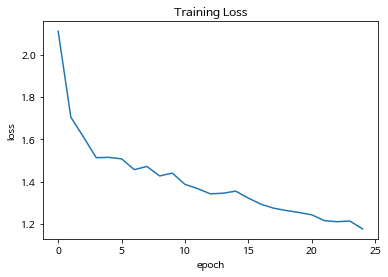

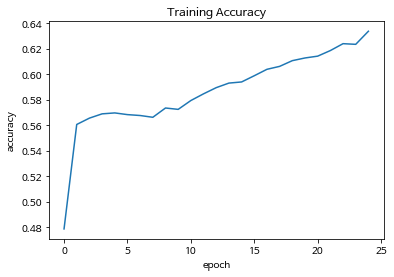

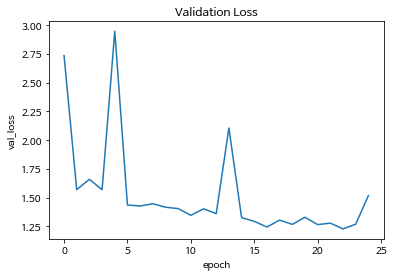

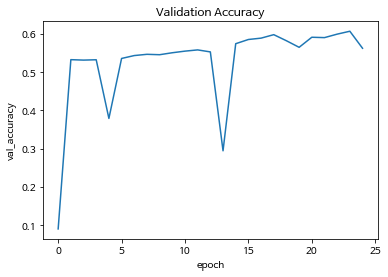

In [31]:
loss = keras.losses.SparseCategoricalCrossentropy()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=25)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

# 결과

In [35]:
# Loading the Colormap
colormap = loadmat(
    "D:/Dataset/dataset/Sementic_Segmentation/instance-level_human_parsing/human_colormap.mat")["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

1/1 [==============================] - 2s 2s/step


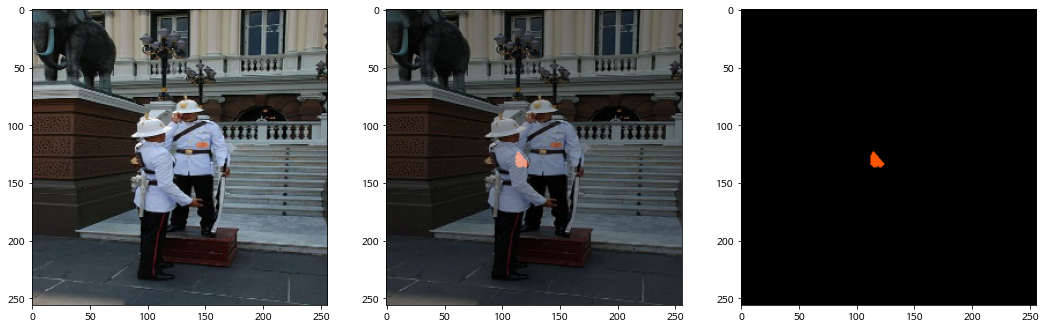

1/1 [==============================] - 0s 18ms/step


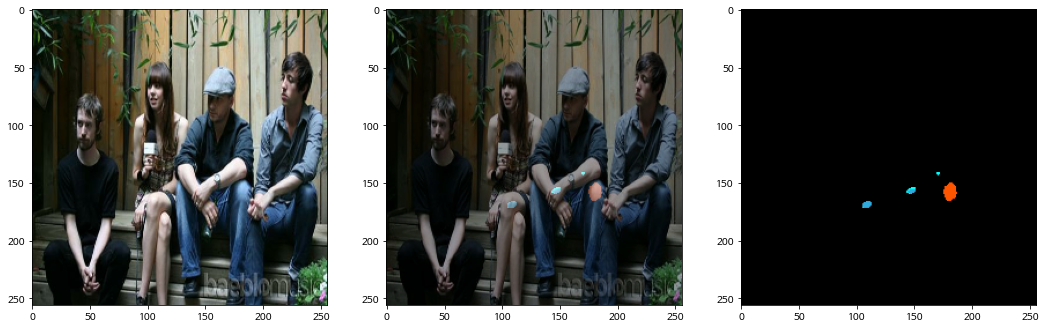

1/1 [==============================] - 0s 18ms/step


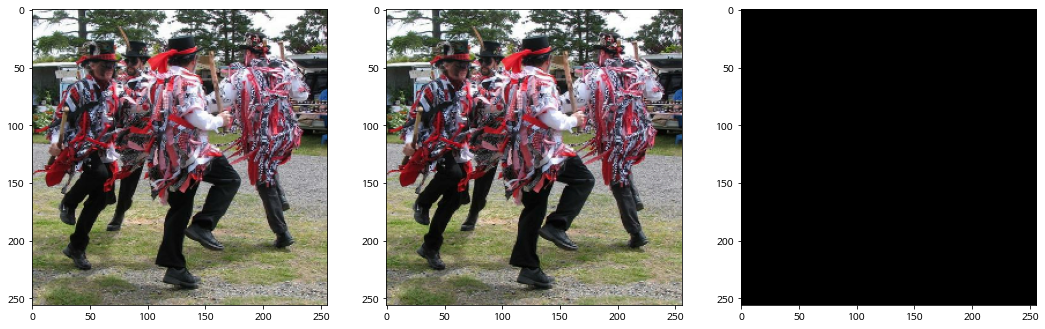

1/1 [==============================] - 0s 19ms/step


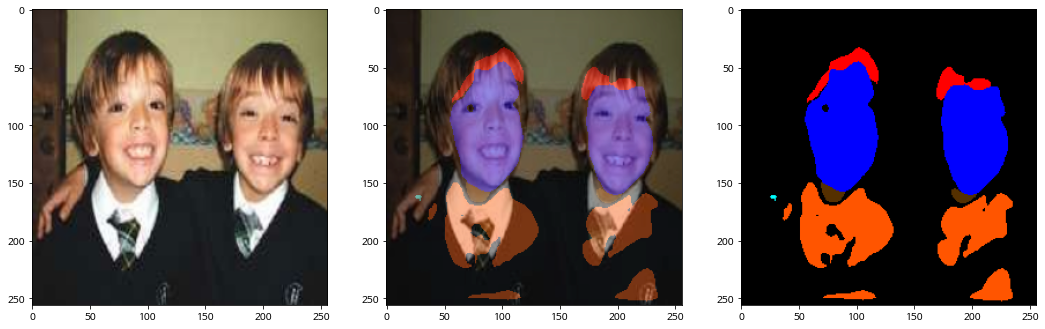

In [36]:
plot_predictions(train_images[:4], colormap, model=model)